# Spam Classification using UCI Data


## Load the required modules
We'll be using pandas for reading data, numpy for basic math ,matplotlib and seaborn for plotting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
%matplotlib inline
sns.set_style('white')
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report

## Get the data
load the data using numpy and give the required column names(label,message)

In [2]:
df = pd.read_csv('dataset/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [3]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


 Let's use **groupby** to use describe by label to know about features that separate ham and spam!

In [5]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Let's create a new column using length of message for a better understanding of the data

In [6]:
df['length'] = df['message'].apply(len)
df.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


## Data Visualization

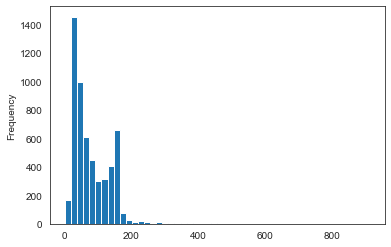

In [7]:
df['length'].plot(kind='hist',bins=50)

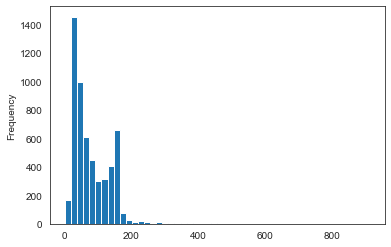

In [8]:
df['length'].plot(bins=50, kind='hist') 


In [9]:
df['length'].describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027B70E783C8>,
      dtype=object)

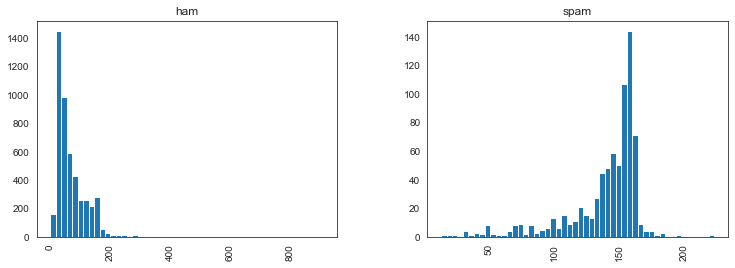

In [10]:
df.hist(column='length', by='label', bins=50,figsize=(12,4))

**Inferences :** Through Basic EDA , we can easily see spam messages are more in length when compared to ham.

## Model Building
### Pre-Processing

In [11]:
def preprocess(text):
    nopunct = [char for char in text if char not in string.punctuation]# remove punctuations
    nopunct = ''.join(nopunct) # join to form a sentence
    return [word for word in nopunct.split() if word.lower() not in stopwords.words('english')] # remove stopwords

We'll be using Countvectorizer as our main preprocessing tool.

We can imagine this as a 2-Dimensional matrix. 

The 1-dimension is the entire vocabulary (1 row per word) and the other dimension are the actual documents, in this case a column per text message.(1- if word is present in the message,0 otherwise)

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message n</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>
Example: Here n=5572 and N= no.of unique words.

For word1 it is present in Message(s)2 and not in 1,n


Lets pass the own preprocess function we defined above as input to the analyzer argument in cv.

In [12]:
cv = CountVectorizer(analyzer=preprocess)

Define input and output

In [13]:
X = df['message']
Y = df['label']

In [14]:
X = cv.fit_transform(X)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=101)

In [16]:
nb = MultinomialNB()

In [17]:
nb.fit(X_train,Y_train)
preds = nb.predict(X_test)

Check the Results

In [18]:
print(confusion_matrix(Y_test,preds))
print('\n')
print(classification_report(Y_test,preds))

[[1435   40]
 [  15  182]]


              precision    recall  f1-score   support

         ham       0.99      0.97      0.98      1475
        spam       0.82      0.92      0.87       197

    accuracy                           0.97      1672
   macro avg       0.90      0.95      0.92      1672
weighted avg       0.97      0.97      0.97      1672



Let's use TF-IDF for this.
Instead of doing one by one,we can define a pipeline and add processes to it and it will do.
So.let's define a pipeline below

In [19]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors by Naive Bayes classifier
])

In [20]:
X = df['message']
Y = df['label']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=101)

In [21]:
pipeline.fit(X_train,Y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [22]:
preds = pipeline.predict(X_test)

Check the results

In [23]:
print(confusion_matrix(Y_test,preds))
print('\n')
print(classification_report(Y_test,preds))

[[1475    0]
 [  72  125]]


              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1475
        spam       1.00      0.63      0.78       197

    accuracy                           0.96      1672
   macro avg       0.98      0.82      0.88      1672
weighted avg       0.96      0.96      0.95      1672



Here is a simple spam classifier.
We can use more advanced techniques such as synonyms,ner etc. for more complex nlp tasks.

## More Resources

Check out the links below for more info on Natural Language Processing:

[NLTK Book Online](http://www.nltk.org/book/) **This is the best one for one's starting on nlp**


[SciKit Learn's Tutorial](http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)